# Author Classification Project

*a thinkful project by Kalika Kay Curry*

Build a project to classify text-author.

Collect thousand texts from Gutenberg project (and 7 novels) for at least 10 authors. 

In [1]:
from urllib import request
import pandas as pd
import en_core_web_sm
import nltk
from nltk.corpus import gutenberg
import re
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
import datetime as dt
import seaborn as sns
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import plotly.express as px
import pickle
import joblib

In [2]:
# Utility function for standard text cleaning
def text_cleaner(text):
    # Visual inspection identifies a form of punctuation that spaCy doesn't
    # recognize: the double dash --. Better get rid of it now!
    text = re.sub(r"\r?\n|\r", " ", text)
    text = re.sub(r'--',' ',text)
    text = re.sub(r"(\b|\s+\-?|^\-?)(\d+|\d*\.\d+)\b", " ", text)
    text = re.sub("[\[].*?[\]]", "", text)
    text = ' '.join(text.split())
    return text

In [3]:
def length_frequencies(text):
    length = [len(w) for w in text]
    fdist = nltk.FreqDist(length)
    return fdist

In [4]:
# Utility function to calculate how frequently words appear in the text
def word_frequencies(text):
    
    # Build a list of words
    # Strip out punctuation
    words = []
    for token in text:
        if not token.is_punct:
            words.append(token.text)
            
    # Build and return a `Counter` object containing word counts
    return Counter(words)

In [5]:
def timer(text):
    print(f'{dt.datetime.now().strftime("%d/%m/%Y %H:%M:%S")}: {text}')

In [6]:
def listtostrings(s):
    return ' '.join([str(elem) for elem in s]) 

In [7]:
#Thousands of Gutenberg texts.
print(f'{dt.datetime.now().strftime("%d/%m/%Y %H:%M:%S")}, started')
text2000 = []
i = 9
count = 0
while count != 2000:    
    try:
        url = f'http://www.gutenberg.org/files/{i}/{i}.txt'
        response = request.urlopen(url)
        raw = response.read().decode('utf8')
        text2000.append(raw )
        count += 1
        i += 1
    except:
        i += 1
print(f'{dt.datetime.now().strftime("%d/%m/%Y %H:%M:%S")}, ended')

26/12/2020 20:26:57, started
26/12/2020 20:49:35, ended


# Authors

The texts from the Gutenberg library does not provide authors in a seperate field. Even the html files don't contain a seperate author field for identifying, easily, who the work is by; so I can't really run a classifier on this yet. 

At the same time, I'm curious who these 2,000 works are by - how many of each author do I have? So a little bit of data exploration and preprocessing to get the authors.

From working with gutenberg data in previous examples, I know that most authors appear within the first 150 characters of the text. Usually it's less than 150 characters, somewhere in the 75 character range. I want the first 150 characters because of this.

In [8]:
#Authors names usually appear within the first 150 characters. 
authors = []
for text in text2000:
    authors.append(text_cleaner(text[0:150]))
print(authors[10:15])

["The Project Gutenberg EBook of Roget's Thesaurus, by Peter Mark Roget This eBook is for the use of anyone anywhere at no cost and with almost no r", 'The Project Gutenberg EBook of The Narrative of the Life of Frederick Douglass, by Frederick Douglass This eBook is for the use of anyone anywhe', 'The Project Gutenberg EBook of O Pioneers!, by Willa Cather This eBook is for the use of anyone anywhere at no cost and with almost no restriction', 'The Project Gutenberg EBook of The CIA World Factbook, by United States. Central Intelligence Agency. This eBook is for the use of anyone a', 'The Project Gutenberg EBook of Paradise Lost, by John Milton ******************************************************************* THIS EBOOK WAS']


In [9]:
#Authors will appears after the word "by"
tokens = nltk.word_tokenize(listtostrings(authors))
authortext = nltk.Text(tokens)

#abandoing this method for - reasons.
first = nltk.text.ConcordanceIndex(authortext).offsets('by') 
example = []
for x in first:
    example.append(authortext[x+1])
print(example[0:15])

['Abraham', 'Charles', 'Lewis', 'United', 'James', 'Anonymous', 'Alexander', 'Henry', 'John', 'Peter', 'Frederick', 'Willa', 'United', 'John', 'Thomas']


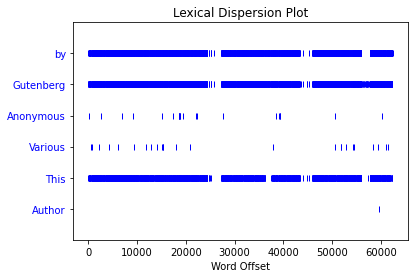

In [10]:
#Looking at how often the words Gutenberg and by appear in the text.
authortext.dispersion_plot(['by', 'Gutenberg', 'Anonymous', 'Various', 'This', 'Author'])

In [11]:
authortext.concordance('Gutenberg')

Displaying 25 of 2007 matches:
The Project Gutenberg EBook of Lincoln 's First Inaugura
 of anyone anywhere a ﻿The Project Gutenberg EBook of The King James Bible * * 
 * EBOOK ( # ) WAS ONE The Project Gutenberg EBook of Through the Looking-Glass
eBook is for the use o The Project Gutenberg EBook of The Hunting of the Snark 
o cost and with almost The Project Gutenberg EBook of The CIA World Factbook , 
r the use of anyone an The Project Gutenberg EBook of Peter Pan , by James M. B
h almost no restrictio The Project Gutenberg EBook of The Book Of Mormon , by A
with almost no restric The Project Gutenberg EBook of The Federalist Papers , b
r the use of anyone an The Project Gutenberg EBook of The Song Of Hiawatha , by
no cost and with almos The Project Gutenberg EBook of Paradise Lost , by John M
h almost no restrictio The Project Gutenberg EBook of Roget 's Thesaurus , by P
t and with almost no r The Project Gutenberg EBook of The Narrative of the Life
e use of anyone anywhe The Proje

In [12]:
#This is the best that I can do. 
name = []
for x in authors:
    first = x.find('by') + len('by ')
    last = x.find('This') 
    if last == -1:
        last = x.find('*')
    name.append(text_cleaner(x[first:last].strip("*")))
print(name[0:25])

['Abraham Lincoln', 'he Project Gutenberg EBook of The King James Bible', 'Charles Dodgson AKA Lewis Carroll', 'Lewis Carroll', 'United States. Central Intelligence Agency', 'James M. Barrie', 'Anonymous', 'Alexander Hamilton and John Jay and James Madison', 'Henry W. Longfellow', 'John Milton', 'Peter Mark Roget', 'Frederick Douglass', 'Willa Cather', 'United States. Central Intelligence Agency.', 'John Milton', 'Thomas Hardy', 'Aesop', 'United States Bureau of the Census', 'Various', 'Sophocles', 'Charlotte Perkins Stetson Gilman', 'Nathaniel Hawthorne', 'Brendan P. Kehoe', 'H. G. Wells', 'United States Bureau of the Census']


In [13]:
d = { 'author': name, 'text': text2000}
df = pd.DataFrame(d)

In [14]:
#update a few of the noticeable errors. Technically, I shouldn't handle it this way since the files may update at any time. Perhaps I'll just leave it as is. :/
df['author'][1] = 'Various'
df.author[1998] = 'Fannie Isabelle Sherrick'
#Clean the text, like for authors.
df['text'].apply(lambda x: text_cleaner(x))
df.head()

,author,text
0,Abraham Lincoln,The Project Gutenberg EBook of Lincoln's First...
1,Various,﻿The Project Gutenberg EBook of The King James...
2,Charles Dodgson AKA Lewis Carroll,The Project Gutenberg EBook of Through the Loo...
3,Lewis Carroll,The Project Gutenberg EBook of The Hunting of ...
4,United States. Central Intelligence Agency,The Project Gutenberg EBook of The 1990 CIA Wo...


In [15]:
df.head()

,author,text
0,Abraham Lincoln,The Project Gutenberg EBook of Lincoln's First...
1,Various,﻿The Project Gutenberg EBook of The King James...
2,Charles Dodgson AKA Lewis Carroll,The Project Gutenberg EBook of Through the Loo...
3,Lewis Carroll,The Project Gutenberg EBook of The Hunting of ...
4,United States. Central Intelligence Agency,The Project Gutenberg EBook of The 1990 CIA Wo...


<AxesSubplot:xlabel='author', ylabel='count'>

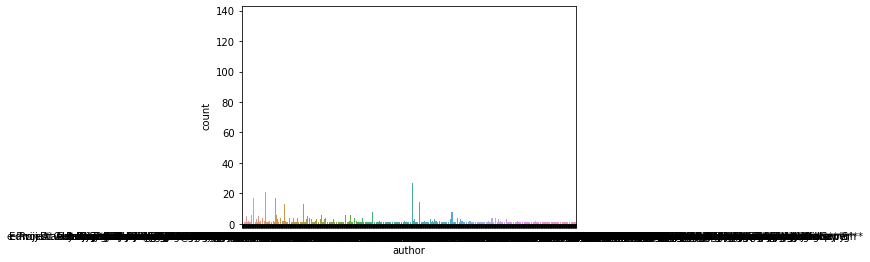

In [16]:
sns.countplot(data=df, x='author')

In [17]:
df[df.author == '']

,author,text
329,,***The Project Gutenberg Etext of The Hymns of...
352,,"**The Project Gutenberg Etext of The Crowd, by..."
355,,**The Project Gutenberg Etext of The Psycholog...
356,,****The Project Gutenberg Etext of Pathology o...
361,,"***The Project Gutenberg Etext of ""The Breitma..."
...,...,...
1836,,\r\n\r\n\r\n\r\n******************************...
1897,,**This is a COPYRIGHTED Project Gutenberg Etex...
1986,,***Project Gutenberg Etext: The Circus Boys Ac...
1987,,***Project Gutenberg Etext: The Circus Boys In...


I have 136 rows of unknown authors. I will assign these to a hold out variable that could, potentially, be used to extract authors using a machine learning model.

I shall call the variable - holdout.

In [18]:
holdout = df[df.author == ''].copy()
holdout.head()

,author,text
329,,***The Project Gutenberg Etext of The Hymns of...
352,,"**The Project Gutenberg Etext of The Crowd, by..."
355,,**The Project Gutenberg Etext of The Psycholog...
356,,****The Project Gutenberg Etext of Pathology o...
361,,"***The Project Gutenberg Etext of ""The Breitma..."


In [19]:
df.author.replace('', float("NaN"), True)
df.dropna(inplace=True)

Have a look at the authors that are reading as excessively long and update their names so that they register as authors without the extra information. 

In [20]:
pd.options.display.max_seq_items = 1000
df.author.value_counts().index

Index(['Honore de Balzac', 'Richard Harding Davis', 'Thomas Carlyle', 'Plato',
       'Joseph Conrad', 'Jack London', 'Various', 'Henry James',
       'Arthur Conan Doyle', 'Charles Dickens',
       'Shakespeare PG has multiple editions of William Shakespeare's Complete Works',
       'Anonymous', 'Edgar Rice Burroughs', 'Jerome K. Jerome', 'Bret Harte',
       'L. Frank Baum', 'Wilkie Collins', 'Victor Appleton',
       'Robert Louis Stevenson', 'Xenophon', 'Unknown',
       'Mary Roberts Rinehart', 'Rudyard Kipling', 'H. G. Wells',
       'Jules Verne', 'Nathaniel Hawthorne', 'Kate Douglas Wiggin',
       'Zane Grey', 'Edith Wharton', 'Booth Tarkington',
       'Frances Hodgson Burnett', 'Max Beerbohm', 'Alice Meynell',
       'Andrew Lang', 'Robert Nemiroff and Jerry Bonnell',
       'E. Phillips Oppenheim', 'Sir Walter Scott', 'Owen Wister',
       'George MacDonald', 'O. Henry', 'Thomas Babington Macaulay',
       'Thomas Bailey Aldrich', 'Thomas Hardy', 'George Bernard Shaw',
   

In [21]:
corrections = ['Hesther Lynch Piozzi','Beatrix Potter','Susan Fenimore Cooper','Baker','Hale','Cunninghame Graham','Charles Oliver', 'William Makepeace Thackeray', 
               "Shakespeare", 'James Russell Lowell', 'Henry Wadsworth Longfellow', 'Andrew Dickson White', 'Ayn Rand', 'Fannie Isabelle Sherrick', 'John Lord', 'James Lane Allen',
               'Jack London', 'William Wells Brown', 'Thomas A Kempis', "Alexander Pope", 'Louis Ginzberg', 'Jerome K. Jerome', 'Maurice Maeterlinck', 'George Wharton James', 
                'Rudyard Kipling', 'Jerome Lobo', 'James F. Cooper', 'Charles Dickens', 'Upton Sinclair', 'Johanna Spyri', 'William and Ellen Craft', 
               'James Whitcomb Riley', 'Helen Beecher Long', 'Joseph-Pierre Proudhon', 'Arthur Brisbane', 'Julian Hawthorne', 'R. M. Ballantyne']
for corr in corrections:
    df.loc[df.author.str.contains(corr), 'author'] = corr

There are a lot of these and more keep turning up. Manual interpretation didn't work out too well for me and neither did my programmatical magic - so I'm going to hold out on these, too.

In [22]:
copyright = df.loc[df.author.str.contains("Copyright")]
holdout = pd.concat([copyright, holdout])

In [23]:
df.loc[df.author.str.contains("Copyright")] = float("NaN")
df.dropna(inplace=True)

See the bag of words explanation on this part. I need/want to handle the data cleaning up here so we can see it all at once. 

There are too many sentences to process the bag of words so I need to reduce my author count. It doesn't make sense to include anonymous/unknown/various authors in my training model. How can I train in that scenario? So - remove multiple authors (authors containing the word and), various, editors, unknown, illustrated, aliases (AKA), anyone author with a parenthsis, and anonymous. 

In [24]:
#Unknowns, etc.
unknowns = [' and ', 'various', 'anonymous', 'unknown', 'enty years after', 'gutenberg', '\(', 'edited', 'illustrated']
various = df.loc[df.author.str.lower().str.contains('|'.join(unknowns))]

holdout = pd.concat([various, holdout])

#aliases that are labeled with AKA. 
alias = df.loc[df.author.str.contains('AKA')]

holdout = pd.concat([alias, holdout])

In [25]:
df.loc[df.author.str.lower().str.contains('|'.join(unknowns))] = float("NaN")
df.dropna(inplace=True)

In [26]:
df.loc[df.author.str.contains('AKA')] = float("NaN")
df.dropna(inplace=True)

In [27]:
df.author.value_counts()

Honore de Balzac         92
Shakespeare              52
Charles Dickens          27
Richard Harding Davis    27
Thomas Carlyle           27
                         ..
Sextus Propertius         1
Sara Jeanette Duncan      1
Richard le Gallienne      1
E. V. Lucas               1
Mary Johnston             1
Name: author, Length: 665, dtype: int64

Balance out the dataset by holding out on all works greater than the mean; that is, reduce those authors count to three. 

In [28]:
author_counts = df.author.value_counts()[0:50]
keep = author_counts[author_counts.values > 3]

In [29]:
#Remove all the works after the first three, because we only want three of them. 
for a in keep.index:
    remove_index = df[df.author.isin([a])][3:].index
    remove = df[df.author.isin([a])][3:].copy()
    holdout = pd.concat([remove, holdout])
    df.drop(remove_index, inplace=True)

In [30]:
# #Choose 100 authors
# keep = df.author.value_counts()

# for a in keep.index:
#     remove_index = df[~df.author.isin([a])].index
#     remove = df[~df.author.isin([a])].copy()
#     holdout = pd.concat([remove, holdout])
#     df.drop(remove_index, inplace=True)
# holdout.head()

,author,text
192,Robert W. Service,The Project Gutenberg EBook of Ballads of a Ch...
238,Robert W. Service,"Project Gutenberg's Rhymes of a Rolling Stone,..."
244,Robert W. Service,"Project Gutenberg's Rhymes of a Red Cross Man,..."
0,Abraham Lincoln,The Project Gutenberg EBook of Lincoln's First...
3,Lewis Carroll,The Project Gutenberg EBook of The Hunting of ...


In [31]:
# #I should have done something different. This is a fix to get the data back that I accidentally eradicated from the dataframe. 
# df = holdout[holdout.author.isin(keep.index)]
# holdout = holdout[~holdout.author.isin(keep.index)]

The NLP generated some kind of an error message when the text exceeded a number of characters. 
The following steps were taken:
> Increased page file size.

> Set PC properties to maximize peformance.

> Reduced the variable t to translate at that amount. 

*note: originally I had run nlp against all 2,000 records to set them out as documents. This made it such that the hold out dataframe also contained documents that I could access at a later date. Unfortunately, it took over four hours to process all 2k records, the large dataset caused frequent lagging and I would often have to reboot my computer; slowing down the project. So this step was moved to after the data cleaning process wherein I selected my dataset based on the number of authors.*

In [32]:
#Now is the time. Turn these text fields into documents.
nlp = en_core_web_sm.load()
doc = []
author = []
i = 0
df['doc'] = ""
df['no_stop'] = ""
# All the processing work takes place below, so it may take a while.
for index, t in df.iterrows():
    print(f'{dt.datetime.now().strftime("%d/%m/%Y %H:%M:%S")} working on doc {i}')
    #try to process the text file into a document. Skip it if it can't. As many as possible.
    try:
        #500000 characters seems long enough for this exercise. I just want to identify the author - which is a text field labled "Author:" or whoever is after the "by" statement. 
        t['doc'] = nlp(t.text[0:500000])
        t['no_stop'] =  [token for token in t.doc if not token.is_stop]
        i += 1
    except:
        i += 1
        print("encountered an exception, skipping to next document.")

26/12/2020 20:52:03 working on doc 0
26/12/2020 20:52:07 working on doc 1
26/12/2020 20:52:12 working on doc 2
26/12/2020 20:52:17 working on doc 3
26/12/2020 20:52:30 working on doc 4
26/12/2020 20:52:36 working on doc 5
26/12/2020 20:52:50 working on doc 6
26/12/2020 20:52:52 working on doc 7
26/12/2020 20:53:06 working on doc 8
26/12/2020 20:53:19 working on doc 9
26/12/2020 20:53:31 working on doc 10
26/12/2020 20:53:38 working on doc 11
26/12/2020 20:53:44 working on doc 12
26/12/2020 20:53:47 working on doc 13
26/12/2020 20:53:57 working on doc 14
26/12/2020 20:54:09 working on doc 15
26/12/2020 20:54:17 working on doc 16
26/12/2020 20:54:25 working on doc 17
26/12/2020 20:54:26 working on doc 18
26/12/2020 20:54:36 working on doc 19
26/12/2020 20:54:49 working on doc 20
26/12/2020 20:55:01 working on doc 21
26/12/2020 20:55:13 working on doc 22
26/12/2020 20:55:25 working on doc 23
26/12/2020 20:55:38 working on doc 24
26/12/2020 20:55:41 working on doc 25
26/12/2020 20:55:53 wo

In [33]:
dist_plot = df[['author', 'doc']].iloc[0]
length = [len(w) for w in dist_plot.doc]
fdist = nltk.FreqDist(length)
fdist.plot()

IndexError: single positional indexer is out-of-bounds

In [ ]:
# Instantiate your list of the most common words
word_freq = word_frequencies(df[df.author == 'Honore de Balzac']['doc'].iloc[0]).most_common(10)
print(word_freq)

In [ ]:
# Grouping by sentences for each of these documents. 
list_sentences = []

for index, row in df.iterrows():
    list_sentences += ([[sent, row.author, row.doc[0:500]] for sent in row.doc.sents])
    
# Combine the sentences from the two novels into one DataFrame
sentences = pd.DataFrame(list_sentences, columns = ["sentences", "author", 'title'])
sentences.head()

In [ ]:
# Get rid of stop words and punctuation and lemmatize the tokens
for i, sentence in enumerate(sentences["sentences"]):
    sentences.loc[i, "sentences"] = [token.lemma_ for token in sentence if not token.is_punct and not token.is_stop]

Natural language processing is taking over 4 hours to complete. It takes about a half hour to complete download the files from the internet. 

I am exporting the data object using pickle so that I can access the object in case I have to reboot. 
I've got to run a grid search, yet. 

I receive the following error when I attempt to pickle the tokens and sentences:
```
NotImplementedError: [E111] Pickling a token is not supported, because tokens are only views of the parent Doc and can't exist on their own. A pickled token would always have to include its Doc and Vocab, which has practically no advantage over pickling the parent Doc directly. So instead of pickling the token, pickle the Doc it belongs to.
```

The pickle file, at this juncture (100 authors) , is well over 25 GB, so I'm saving just the doc and the author from the dataframe. 

Last, but not least, the file is being saved outside of the project folder because it's too big for GitHub.


In [35]:
#Pickle the author and doc in case I have to reboot. 
timer('pickling dataframes.')

with open("..\d_store\data.pkl", 'wb') as f:
    pickle.dump(df[['author', 'doc']], f)

timer('done pickling dataframes')

27/12/2020 09:57:38: pickling dataframes.
27/12/2020 10:06:46: done pickling dataframes


Well when I was processing at 100 authors, I could write the file, but not read it. 

I got the following 
``` MemoryError: Error assigning 4916400 bytes ```

I'm looking at the amount of time it takes to load and the number of documents it can process.
It's between 354 and 1,000.

In [36]:
timer("opening the data")
with open("..\d_store\data.pkl", 'rb') as f:
    blap = pickle.load(f)
timer("done opening the data.")

27/12/2020 10:06:46: opening the data
27/12/2020 10:16:56: done opening the data.


In [41]:
type(blap.doc.iloc[0])

spacy.tokens.doc.Doc

When pickle timed out at 1,000 documents, I started looking for alternatives. This is what joblib looks like.

Joblib got it's first shot at 354 documents. 

In [43]:
timer("saving")
joblib.dump(df[['author', 'doc']], "..\d_store\data.sav")
timer('done saving')

27/12/2020 10:48:18: saving
27/12/2020 11:39:19: done saving


In [44]:
timer('loading')
blaj = joblib.load("..\d_store\data.sav")
timer('done loading')

27/12/2020 11:39:23: loading
27/12/2020 12:11:54: done loading


In [45]:
type(blaj.doc.iloc[0])

spacy.tokens.doc.Doc

# Bag of Words

For bag of words, I have to troubleshoot a memory error. 

`MemoryError: Unable to allocate 27.0 TiB for an array with shape (6566859, 565300) and data type int64`

Step One: Reduce the size by changing the data type.

> Another error arises when I attempt to mask the shape to an int8.

>```
import numpy as np
mask = np.zeros(X.shape,dtype='uint8')
>```
    
>`MemoryError: Unable to allocate 3.38 TiB for an array with shape (6566859, 565300) and data type uint8`


Step Two: Reduce content by reducing authors.
> Project requirements said ten authors and thousands of texts, with at least seven novels. 

> I returned to the data cleaning process to eliminate various/anonymous/unknown authors.

> I still get an error.

> `MemoryError: Unable to allocate 16.1 TiB for an array with shape (5928859, 373831) and data type int64`

Step Three: Reduce content again by reducing authors in a way such that the dataset is more balanced. 
>I returned to the data cleaning process to reduce the number of works of those largest authors to three or four. 

>Received a similar memory error. 

Step Four: Skip the dataframe, train the model.

> Received a similar memory error and the entire system locked up. 

Step Five: Reduce the number of authors.  
> ```Unable to allocate 7.31 GiB for an array with shape (2952352, 665) and data type int32```

> Return to data cleaning and choose the top 100 authors. Decrease steadily until the program runs. 

In the interest of keeping things easy and to the point; I'll be refraining from adding the error messages. The logistic regression was taking an excessive amount of time to run. I attempted to shape the data into a dataframe again and received an error mentioning 2.77 TiB for 100 authors. 

In [58]:
y = sentences['author']
X = sentences['sentences']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [59]:
vectorizer = CountVectorizer(analyzer='word')
X_train = vectorizer.fit_transform(X_train.astype(str))
X_test = vectorizer.transform(X_test.astype(str))

In [61]:
bow_df = pd.DataFrame(X_train.toarray(), columns=vectorizer.get_feature_names())
bow_sents = pd.concat([bow_df, sentences[["text", "author"]]], axis=1)

MemoryError: Unable to allocate 2.77 TiB for an array with shape (2314536, 164250) and data type int64

In [60]:
#Test on logistic regression to see if it runs. Expand from here. 
lr = LogisticRegression()
lr.fit(X_train, y_train)
print(classification_report(y_test, lr.predict(X_test)))

KeyboardInterrupt: 

In [ ]:
# results = model_results('bow', X_train.toarray(), X_test.toarray(), y_train, y_test)
# results

In [ ]:
#Some constant variables for parameter settings. 
#cross validation, constant parameter
cv = 5

#multiclass
mc = ['auto', 'ovr', 'multinomial']
#solver
sv = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
#penalty
py = ['l1', 'l2', 'elasticnet', 'none']
#criterion
cn = ['gini', 'entropy']
#max_features
mf = ['auto', 'sqrt', 'log2']
#splitter
sr = ['best', 'random']
#max_depth
md = [5, 7, 15, 29] 
#n_estimators
ne = [n+50 for n in range(50, 500, 50)]  


In [ ]:
#logistic regression
lrp = {    "lr__multi_class": mc, 
           "lr__solver": sv,
           'lr__penalty' : py,
      }
#decision tree
dtp = {
           'dt__criterion': cn,
           'dt__max_features': mf,
           'dt__splitter':sr, 
           'dt__max_depth': md     
}
#K Nearest Neighbors
knnp = {
           'knn__n_neighbors': [3, 9, 39, 12],
           'knn__weights': ['uniform', 'distance'],
           'knn__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'], 
           'knn__leaf_size': [30, 12, 9, 3, 17],  
           'knn__metric': ['mahalanobis','euclidean', 'manhattan', 'chebyshev', 'minkowski', 'seuclidean'],  
}
#Support Vector Classifier
svp = {
          'sv__kernel': ['linear', 'rbf'],
          'sv__break_ties': [True, False],
}
#Random Forest Classifier 
rfp = {
           'rf__criterion': cn,
           'rf__max_features': mf,
           'rf__oob_score':[True, False], 
           'rf__max_depth': md,
           'rf__n_estimators': ne,     
}
#gradient boost 
gbp = {    'gb__criterion': ['friedman_mse', 'mse', 'mae'],
           'gb__max_features': mf,
           'gb__max_depth': md, 
           'gb__n_estimators': ne
          }
transform = { 'vectorizer__analyzer': word }

In [ ]:
from sklearn.naive_bayes import ComplementNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

In [ ]:
#Naive Bayes Update pipeline with parameters and classifiers.
pipeline = Pipeline([('vectorizer', CountVectorizer(analyzer='word')), ('nb', ComplementNB())])
params = transform
search = GridSearchCV(pipeline, params, cv=cv)
print(f'{dt.datetime.now().strftime("%d/%m/%Y %H:%M:%S")}, started grid search')
search.fit(X_train, y_train)
print(f'{dt.datetime.now().strftime("%d/%m/%Y %H:%M:%S")}, grid search complete')

In [ ]:
,
                     ('rf', RandomForestClassifier(random_state=1)),
                     ('lr', LogisticRegression()),
                     ('gb', GradientBoostingClassifier()),
                     ('knn', KNeighborsClassifier()),
                     ('sv', SVC()),
                     ('dt', DecisionTreeClassifier())
                    

In [ ]:
bow_model = search.best_estimator_

bow_model.fit(X_train, y_train)
y_pred = bow_model.predict(X_test)

print(classification_report(y_test, y_pred))